# Web Log analysis using apache spark and HDFS
## Vivek Shah | CE 126, CE Dept., DDU

#### Connect On:
- [Github](https://github.com/vivekshah1801)
- [LinkedIn](https://www.linkedin.com/in/vivekshah1801/)
- [Twitter](https://twitter.com/vivekshah1801)
- [Website](https://vivekshah.tech)
- [Email](mailto:vivekshah9969@gmail.com)

# Problem Description

### **Weblogs analysis using apache spark.**

This project is the to demonstrate the functionality of spark and hadoop for large scale distributed processing.\
The script will take log data from HDFS storage and does on-memory processing using spark.\
Script outputs insights generated by log data processing.

# Prerequisites

- Processing: Apache Spark 3.0.0 (Supported by hadoop 3.2)
- Data Store: Apache Hadoop 3.2.1
- DataSet: NASA server access logs 1995 [Kaggle DataSet Link](https://www.kaggle.com/souhagaa/nasa-access-log-dataset-1995 "NASA access log dataset 1995")
<hr>
- Spark Home, Hadoop Home, Java Home variables should be properly set up.
- Hadoop, HDFS shoulbe be working
- Spark should be running

# Data Location

Once downloaded, we will save the csv file of log to hadoop's hdfs.

Benifits of storing file to HDFS:
- Can handle big files over hadoop cluster
- Fault tolerance
- Parallelism, as every worker machine of spark can get the HDFS file.

# Putting Data to HDFS

In [1]:
# putting data from local to HDFS
# data is stored in "/home/hadoop/projects_bd/web_log_spark/data/nasa1995_weblogs.csv" in local system.


# HDFS commands (to run in terminal)
!hdfs dfs -mkdir /user/hadoop/WebLogData
!hdfs dfs -copyFromLocal /home/hadoop/projects_bd/web_log_spark/data/nasa1995.log /user/hadoop/WebLogData

mkdir: `/user/hadoop/WebLogData': File exists
copyFromLocal: `/user/hadoop/WebLogData/nasa1995.log': File exists


In [2]:
# Checking the file is available in HDFS

!hdfs dfs -ls /user/hadoop/WebLogData/nasa1995.log

-rw-r--r--   3 hadoop supergroup  240939664 2020-09-07 10:10 /user/hadoop/WebLogData/nasa1995.log


# Initialize Spark

In [3]:
# findspark adds PySpark to sys.path at runtime. Making this code portable.

import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("WebLogAnalyzer") \
    .getOrCreate()

In [5]:
spark

# Loading and Exploring Data

In [6]:
# both the paths has same contents.
data_hdfs_path = "hdfs://127.0.0.1:9000/user/hadoop/WebLogData/nasa1995.log"
data_path = "data/nasa1995.log"

In [58]:
df = spark.read.csv(data_hdfs_path,header=True, \
                    schema="id INT, host STRING, time INT, method STRING, url STRING, reponse INT, bytes INT")

Make sure you pass schema argument correctly.

Otherwise you can also pass the inferSchema=True, which will infer the schema itself.
But that will add one more pass on the data.

In [84]:
# converting time to datetime

from pyspark.sql import functions
from pyspark.sql import types

df = df.withColumn('datetime', (df["time"].cast(dataType=types.TimestampType())))

# took help from: 
# https://stackoverflow.com/questions/49971903/converting-epoch-to-datetime-in-pyspark-data-frame-using-udf

In [85]:
type(df) # df is a spark dataframe. A datastructure on top of spark RDD.

pyspark.sql.dataframe.DataFrame

In [86]:
df.dtypes

[('id', 'int'),
 ('host', 'string'),
 ('time', 'timestamp'),
 ('method', 'string'),
 ('url', 'string'),
 ('reponse', 'int'),
 ('bytes', 'int'),
 ('time1', 'timestamp'),
 ('datetime', 'timestamp')]

In [87]:
df.show(10)

+---+-----------+-------------------+------+--------------------+-------+-----+-------------------+-------------------+
| id|       host|               time|method|                 url|reponse|bytes|              time1|           datetime|
+---+-----------+-------------------+------+--------------------+-------+-----+-------------------+-------------------+
|  0|***.novo.dk|1995-07-11 17:47:09|   GET|           /ksc.html|    200| 7067|1995-07-11 17:47:09|1995-07-11 17:47:09|
|  1|***.novo.dk|1995-07-11 17:47:11|   GET|/images/ksclogo-m...|    200| 5866|1995-07-11 17:47:11|1995-07-11 17:47:11|
|  2|***.novo.dk|1995-07-11 17:47:31|   GET|/images/MOSAIC-lo...|    200|  363|1995-07-11 17:47:31|1995-07-11 17:47:31|
|  3|***.novo.dk|1995-07-11 17:47:33|   GET|/images/USA-logos...|    200|  234|1995-07-11 17:47:33|1995-07-11 17:47:33|
|  4|***.novo.dk|1995-07-11 17:47:34|   GET|/images/NASA-logo...|    200|  786|1995-07-11 17:47:34|1995-07-11 17:47:34|
|  5|***.novo.dk|1995-07-11 17:47:38|   

In [35]:
df.count()

2965561

We can see the data has 6 columns ie. 
- host
- timestamp of the request
- HTTP access method
- resource requested
- HTTP status code
- Bytes sent in response

Data consists 2965561 data rows, amounting for 230 MB.

# Analysis of web log data

## How many requests are logged in the data?

In [12]:
df.count()

2965561

## How many request were success? (ie. has 2XX response)

In [13]:
df.groupby("response").count().collect()

[Row(response=501, count=30),
 Row(response=404, count=3858),
 Row(response=200, count=2696600),
 Row(response=304, count=258161),
 Row(response=302, count=6912)]

Total 2696600 requests were success.

**We can say : total 90.9305% request successfully served.**

## Total Bytes Transmitted by the server

In [21]:
from pyspark.sql.functions import sum

df.agg(sum("bytes")).collect()

[Row(sum(bytes)=43159977733)]

Total 43159977733 bytes were transmitted by server in year 1995.

It will be equivalent to 43.16 GB of data.

## Max request in a day

In [139]:
df.groupBy(to_date(df["datetime"])).agg(count("datetime").alias("count")).agg(max("count")).show()

+----------+
|max(count)|
+----------+
|    119422|
+----------+



NASA had 1,19,422 requests in a day.

That amounts to approx 83 requests/minute.

## Nasa's Prime-time Hour

In [157]:
df.groupBy(hour(df["datetime"]).alias("hour")) \
    .agg(sum("bytes").alias("bytes_served_hour")) \
    .sort("bytes_served_hour", ascending=False) \
    .show(5)

df.groupBy(hour(df["datetime"]).alias("hour")) \
    .agg(count("datetime").alias("request_count")) \
    .sort("request_count", ascending=False) \
    .show(5)

+----+-----------------+
|hour|bytes_served_hour|
+----+-----------------+
|  22|       2813513682|
|   1|       2787547911|
|   0|       2715306325|
|  23|       2656899867|
|  21|       2620734720|
+----+-----------------+
only showing top 5 rows

+----+-------------+
|hour|request_count|
+----+-------------+
|   1|       198147|
|  22|       197380|
|   0|       192530|
|  23|       191465|
|  21|       189455|
+----+-------------+
only showing top 5 rows



Nasa had high traffic from hour 22:00 to 23:00 in terms of bytes served.

And 1:00 to 2:00 in terms of request it served.

# Most Busy Day

In [162]:
df.groupBy(to_date(df["datetime"]).alias("date")) \
    .agg(sum("bytes").alias("bytes_served_date")) \
    .sort("bytes_served_date", ascending=False) \
    .show(5)

df.groupBy(to_date(df["datetime"]).alias("date")) \
    .agg(count("datetime").alias("request_count")) \
    .sort("request_count", ascending=False) \
    .show(5)

+----------+-----------------+
|      date|bytes_served_date|
+----------+-----------------+
|1995-07-13|       1825748454|
|1995-07-07|       1569873752|
|1995-07-06|       1568302856|
|1995-07-04|       1430267703|
|1995-07-03|       1388025005|
+----------+-----------------+
only showing top 5 rows

+----------+-------------+
|      date|request_count|
+----------+-------------+
|1995-07-13|       119422|
|1995-07-07|        85842|
|1995-08-31|        84805|
|1995-07-06|        82786|
|1995-07-14|        76598|
+----------+-------------+
only showing top 5 rows



**As 13th July 1995, is the busiest day**

I checked the events which might be the potential reasons behind this surge in request.

Turned out, NASA launched space shuttle "Discovery" at Kennedy Space Center.

Source: https://www.nasa.gov/mission_pages/shuttle/shuttlemissions/archives/sts-70.html

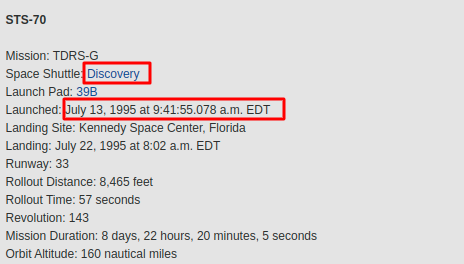

# Challenges Faced

- Grasping the concepts of spark, how it works, RDDs, SparkSession.
- Converting from int to datetime for time column
- Performance improvements. (Partitions, schemaInferance, UDF vs Spark built-ins)

# Future Possibilities

- Running the program on large spark cluster, probably on some cloud infrastrucure. (Azure/AWS databricks)
- The analytics can be stored in json, and later fed to a html page to visualize using charts and graphs.
- Adding more insights.

### References

- Official Spark Documentation: https://spark.apache.org/
- For understanding syntax and quick refresher on concepts: https://www.udacity.com/course/learn-spark-at-udacity--ud2002
- For troubleshooting: https://stackoverflow.com

# Vivek Shah | vivekshah9969@gmail.com

Made for BDA assignment 05. 

This Doc can be viewed online at https://github.com/vivekshah1801/Apache-Spark-Web-Log-Analysis